# 0. Install and Import Dependencies

In [1]:
!pip list

Package                      Version
---------------------------- -----------
absl-py                      2.1.0
asgiref                      3.7.2
asttokens                    2.2.1
astunparse                   1.6.3
backcall                     0.2.0
beautifulsoup4               4.11.1
certifi                      2023.11.17
charset-normalizer           2.1.1
click                        8.1.3
colorama                     0.4.6
comm                         0.2.0
contourpy                    1.1.0
cycler                       0.11.0
debugpy                      1.6.7
decorator                    5.1.1
Django                       4.2.7
django-cors-headers          4.3.1
django-messages              0.6.0
djangorestframework          3.15.1
dnspython                    2.4.2
emoji                        1.7.0
exceptiongroup               1.2.0
executing                    1.2.0
Flask                        2.1.3
Flask-MySQLdb                2.0.0
flatbuffers                  24.3.25
fo

In [2]:
!pip install opencv-python matplotlib imageio gdown tensorflow

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     --------------------- ------------------ 30.7/57.6 kB 1.3 MB/s eta 0:00:01
     --------------------- ------------------ 30.7/57.6 kB 1.3 MB/s eta 0:00:01
     -------------------------------------- 57.6/57.6 kB 430.1 kB/s eta 0:00:00
   ---------------------------------------- 0.0/313.5 kB ? eta -:--:--
   ---------- ----------------------------- 81.9/313.5 kB 4.8 MB/s eta 0:00:01
   ---------- ----------------------------- 81.9/313.5 kB 4.8 MB/s eta 0:00:01
   -------------------- ------------------- 163.8/313.5 kB 1.4 MB/s eta 0:00:01
   --------------------------- ------------ 215.0/313.5 kB 1.5 MB/s eta 0:00:01
   ---------------------------------------- 313.5/313.5 kB 1.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/78.3 kB ? eta -:--:--
   ---------------------------------------- 78.3/78.3 kB 4.3 MB/s eta 0

In [3]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [4]:
tf.config.list_physical_devices('GPU')

[]

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [6]:
import gdown

In [7]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=eff19e84-3037-43bb-9e5a-666f353cfbf0
To: c:\Users\HP\Documents\Silent speech recognition\data.zip
100%|██████████| 423M/423M [07:27<00:00, 945kB/s]  


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [8]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [9]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [10]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [11]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [12]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11], dtype=int64)>

In [13]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [14]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [15]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [16]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [17]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [18]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

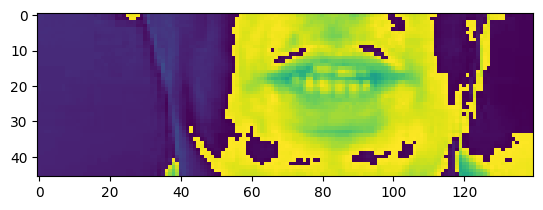

In [19]:
plt.imshow(frames[40])

In [20]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [21]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [22]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [23]:
from matplotlib import pyplot as plt

In [24]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(150)
test = data.skip(450)

In [25]:
len(test)

50

In [26]:
frames, alignments = data.as_numpy_iterator().next()

In [27]:
len(frames)

2

In [28]:
sample = data.as_numpy_iterator()

In [29]:
val = sample.next(); val[0]

array([[[[[ 1.3530405 ],
          [ 1.3530405 ],
          [ 1.3953229 ],
          ...,
          [ 0.        ],
          [ 0.08456503],
          [ 0.08456503]],

         [[ 1.3530405 ],
          [ 1.3530405 ],
          [ 1.3953229 ],
          ...,
          [ 0.        ],
          [ 0.08456503],
          [ 0.08456503]],

         [[ 1.3953229 ],
          [ 1.3953229 ],
          [ 1.3953229 ],
          ...,
          [ 0.        ],
          [ 0.        ],
          [ 0.        ]],

         ...,

         [[ 0.9724978 ],
          [ 0.9724978 ],
          [ 0.9724978 ],
          ...,
          [10.486064  ],
          [10.486064  ],
          [10.486064  ]],

         [[ 0.9724978 ],
          [ 0.9724978 ],
          [ 0.9724978 ],
          ...,
          [10.443781  ],
          [10.443781  ],
          [10.443781  ]],

         [[ 0.9724978 ],
          [ 0.9724978 ],
          [ 0.9724978 ],
          ...,
          [10.443781  ],
          [10.443781  ],
          

In [30]:
# imageio.mimsave('./animation.gif', val[0][0], fps=10)

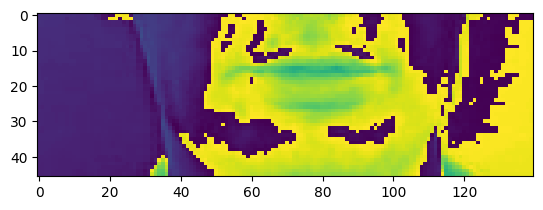

In [31]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video
plt.imshow(val[0][0][35])

In [32]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'place green at k three soon'>

# 3. Design the Deep Neural Network

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [34]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [35]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


ValueError: Could not interpret initializer identifier: Orthogonal

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [ ]:
5*17*75

6375

In [ ]:
yhat = model.predict(val[0])

1/1 [==============================] - 3s 3s/step


In [ ]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'f6666666666666666666666666666666666666666666666666666666666dddddddddddddddd'>

In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'f6666666666666666666666666666666666666666666666666666666666dddddddddddddddd'>

In [ ]:
model.input_shape

(None, 75, 46, 140, 1)

In [ ]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [ ]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
example_callback = ProduceExample(test)

In [ ]:
model.fit(train, validation_data=test, epochs=5, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/5



150/150 [==============================] - ETA: 0s - loss: 103.0140

Epoch 1/5
WARNING:tensorflow:From C:\Users\Isfatul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\backend.py:7169: The name tf.nn.ctc_loss is deprecated. Please use tf.compat.v1.nn.ctc_loss instead.

1/1 [==============================] - 3s 3s/steps - loss: 103.01
Original: place blue at v three soon
Prediction:  e e e e e e e
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set white in b two now
Prediction:  e e e e e e
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
150/150 [==============================] - 1716s 11s/step - loss: 103.0140 - val_loss: 78.3609 - lr: 1.0000e-04
Epoch 2/5
1/1 [==============================] - 2s 2s/steps - loss: 78.79
Original: place white in x two please
Prediction: l e e e e n
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay blue sp with e six please
Prediction: l e e e e e n
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
150/150 [==============================] - 1306s 9s/step - loss: 78.7956 - val_loss: 72.0504 - lr: 1.0000e-04
Epoch 3/5
1/1 [==============================] - 2s 2s/steps - loss: 74.39
Original: bin green in g eight please
Prediction: l e e e o o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin blue with s nine soon
Prediction: le e e e o o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
150/150 [==============================] - 1437s 10s/step - loss: 74.3992 - val_loss: 69.8379 - lr: 1.0000e-04
Epoch 4/5
1/1 [==============================] - 1s 1s/steps - loss: 73.33
Original: lay white at z two please
Prediction: l e e e
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay red with r nine soon
Prediction: l e e e e
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
150/150 [==============================] - 1323s 9s/step - loss: 73.3344 - val_loss: 72.8706 - lr: 1.0000e-04
Epoch 5/5
1/1 [==============================] - 2s 2s/steps - loss: 72.02
Original: set green with x four please
Prediction: la e e e e on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set red at u five again
Prediction: la e e e e on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
150/150 [==============================] - 1212s 8s/step - loss: 72.0203 - val_loss: 67.0663 - lr: 1.0000e-04

# 5. Make a Prediction

In [ ]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=47848061-8b69-4b40-a1f0-ffdb4caa2d1f
To: g:\checkpoints.zip
100%|██████████| 94.5M/94.5M [00:02<00:00, 39.1MB/s]


['models\\checkpoint.index',
 'models\\__MACOSX/._checkpoint.index',
 'models\\checkpoint.data-00000-of-00001',
 'models\\__MACOSX/._checkpoint.data-00000-of-00001',
 'models\\checkpoint',
 'models\\__MACOSX/._checkpoint']

In [ ]:
model.load_weights('models/checkpoint')

ValueError: You are trying to restore a checkpoint from a legacy Keras optimizer into a v2.11+ Optimizer, which can cause errors. Please update the optimizer referenced in your code to be an instance of `tf.keras.optimizers.legacy.Optimizer`, e.g.: `tf.keras.optimizers.legacy.Adam`.

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

KeyboardInterrupt: 

In [ ]:
yhat = model.predict(sample[0])

1/1 [==============================] - 1s 973ms/step


In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'place white at x six please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay blue in x four now'>]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'place white at x six please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay blue in x four now'>]

# Test on a Video

In [ ]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 887ms/step


In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'le '>]